In [1]:
!pip install autogen-agentchat~=0.2 autogen psutil --quiet
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai langchain-anthropic termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import autogen
from typing import Literal

from pydantic import BaseModel, Field
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langgraph.graph import END, StateGraph, START

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"


In [3]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

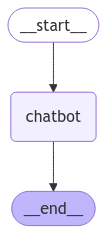

In [4]:
# Visualize your graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# response = graph.invoke("hello")
# print(response.content)

In [6]:
# def stream_graph_updates(user_input: str):
#     for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)


# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break

#         stream_graph_updates(user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
#         break

LangGraph for Beginners, Part 3: Conditional Edges

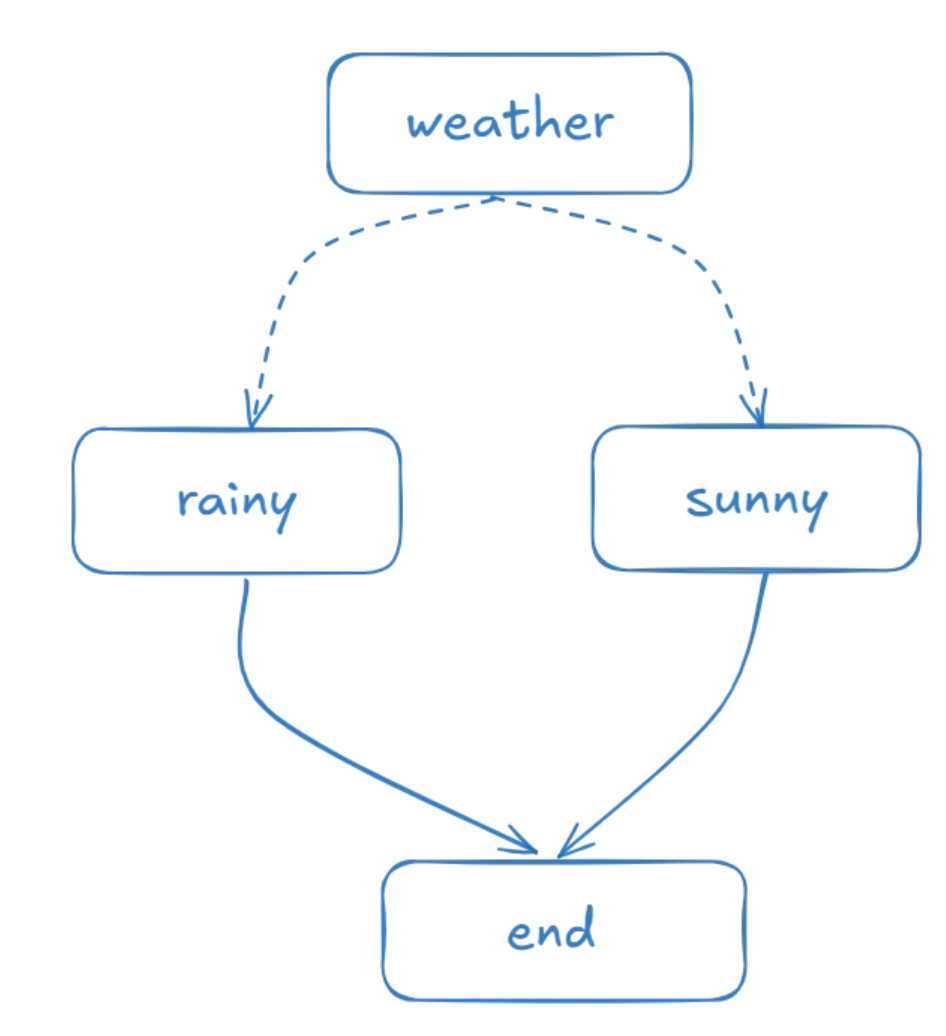

In [7]:
# Define a starting node. This node just returns a predefined string.
def weather(str):
  return "Hi! Well.. I have no idea... But... "

In [8]:
# Define a node that returns rainy weather
def rainy_weather(str):
  return str + " Its going to rain today. Carry an umbrella."

In [9]:
#Define a node that returns sunny weather
def sunny_weather(str):
  return str + " Its going to be sunny today. Wear sunscreen."

In [10]:
import random
from typing import Literal

In [11]:
#create a forecast weather function that returns rainy or sunny weather based on a random number. 
def forecast_weather(str)->Literal["rainy", "sunny"]:
  if random.random() < 0.5:
    return "rainy"
  else:
    return "sunny"

In [12]:
from langgraph.graph import Graph, START, END

# Create a new Graph
workflow = Graph()
# Add the nodes
workflow.add_node("weather", weather)
workflow.add_node("rainy", rainy_weather)
workflow.add_node("sunny", sunny_weather)

# Add the Edges
workflow.add_edge(START, "weather")

workflow.add_conditional_edges("weather", forecast_weather)
workflow.add_edge("rainy", END)
workflow.add_edge("sunny", END)


#Compile the workflow
app = workflow.compile()

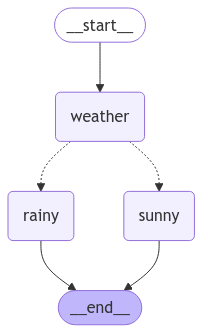

In [13]:
# Visualize your graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
app.invoke('Hi! What does the weather look like? ')
# print(response.content)

'Hi! Well.. I have no idea... But...  Its going to rain today. Carry an umbrella.'

In [15]:
app.invoke("How much is 2+2")
# print(response.content)

'Hi! Well.. I have no idea... But...  Its going to be sunny today. Wear sunscreen.'